In [1]:
from rateslib import *
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log
from numba import jit
import numpy as np 
import pandas as pd
import warnings
import json
import os

Mean Intrinsic Depth Average applied to futures order books for mid price  

Algorithm adapdated from https://github.com/attack68/book_irds3/blob/main/bookirds/mid_market.py 

In [2]:
@jit(nopython=True)
def single_sided_mida(b, w, t):
    sum_w = w.cumsum()
    t = sum_w[-1] if t > sum_w[-1] else t
    n = len(np.where(t > sum_w)[0])
    if n == 0:
        return b[0]
    else:
        sum_bw = (b * w).cumsum()
        p = b[0] * sum_w[0]
        for j in range(1, n):
            p += b[j] * (sum_w[j] - sum_w[j - 1])
            p += (sum_bw[j - 1] - b[j] * sum_w[j - 1]) * (log(sum_w[j]) - log(sum_w[j - 1]))
        p += b[n] * (t - sum_w[n - 1])
        p += (sum_bw[n - 1] - b[n] * sum_w[n - 1]) * (log(t) - log(sum_w[n - 1]))
        return p / t

def mean_intrinsic_depth_average(b, w, a, v, t):
    p_mbida = single_sided_mida(b, w, t)
    p_maida = single_sided_mida(a, v, t)
    return (p_mbida + p_maida) / 2

In [3]:
with open("Data/order_books/all_order_books_0319.json") as f:
    books = json.load(f)

results = []
order_books_by_symbol = {}

z1_indices = set(range(16, 18))
z2_indices = set(range(0, 3)) | set(range(30, 41))
z3_indices = set(range(18, 30))
z4_indices = set(range(3, 16))  
 
#Spread and butterfly mins applied as sum of legs 
z1 = 250 #1 month spread 
z2 = 500 #1 month/3 month butterfly 
z3 = 1000 #3 month spread
z4 = 2000 #3 month 

z_by_index = {}
for i in z1_indices: z_by_index[i] = z1
for i in z2_indices: z_by_index[i] = z2
for i in z3_indices: z_by_index[i] = z3
for i in z4_indices: z_by_index[i] = z4

for i, book in enumerate(books):
    
    z = z_by_index.get(i)

    b = np.array(book["bid_prices"], dtype=float)
    w = np.array(book["bid_sizes"], dtype=float)
    a = np.array(book["ask_prices"], dtype=float)
    v = np.array(book["ask_sizes"], dtype=float)

    # Replace sentinel prices and zero sizes with NaN
    invalid_bids = (b > 1e9) | (w <= 0)
    invalid_asks = (a > 1e9) | (v <= 0)
    b[invalid_bids] = np.nan
    w[invalid_bids] = np.nan
    a[invalid_asks] = np.nan
    v[invalid_asks] = np.nan

    # Filter valid entries
    valid_bids = ~np.isnan(b) & ~np.isnan(w)
    valid_asks = ~np.isnan(a) & ~np.isnan(v)

    b_clean = b[valid_bids]
    w_clean = w[valid_bids]
    a_clean = a[valid_asks]
    v_clean = v[valid_asks]

    if len(b_clean) > 0 and len(a_clean) > 0:
        mid_price = mean_intrinsic_depth_average(b_clean, w_clean, a_clean, v_clean, z)
    else:
        mid_price = None

    results.append({
        "Instrument": book["symbol"],
        "Mid-Price": mid_price
    })

    order_books_by_symbol[book["symbol"]] = pd.DataFrame({
        "Bid Size": w,
        "Bid Price": b,
        "Ask Price": a,
        "Ask Size": v
    })

results_df = pd.DataFrame(results)

In [4]:
order_books_by_symbol["SR3M5"]

,Bid Size,Bid Price,Ask Price,Ask Size
0,1137.0,95.890,95.895,44.0
1,1021.0,95.885,95.900,1390.0
2,1141.0,95.880,95.905,1253.0
3,864.0,95.875,95.910,1211.0
4,1360.0,95.870,95.915,1188.0
5,1280.0,95.865,95.920,1233.0
6,1185.0,95.860,95.925,1013.0
7,1243.0,95.855,95.930,1028.0
8,1205.0,95.850,95.935,1008.0
9,1156.0,95.845,95.940,1156.0


In [5]:
results_df

,Instrument,Mid-Price
0,SR1H5,95.676250
1,SR1J5,95.687500
2,SR1K5,95.735454
3,SR3H5,95.688827
4,SR3M5,95.894570
5,SR3U5,96.131807
6,SR3Z5,96.305187
7,SR3H6,96.421901
8,SR3M6,96.483327
9,SR3U6,96.505654


Computes the core implied instrument prices using the pseudoinverse.

A: The transformation matrix mapping core prices to combined instrument prices 

s: Vector of observed single instrument mid-market prices

Returns core implied prices that minimize the squared error. 

In [6]:
def calculate_core_prices(A, s, w=None):
   
    if w is not None:
        W = np.diag(w)
        p_star = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ s)
    else:
        p_star = np.linalg.pinv(A) @ s
    return p_star

A = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
              [1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1],
              [0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -2, 1]])
s = []

for _, row in results_df.iterrows():
    price = row["Mid-Price"]
    if isinstance(price, float):
        if "-" in row["Instrument"]:
            price = price * 0.01  # If instrument is a spread, convert from ticks to price
        s.append(price)

s = np.array(s)

assert np.linalg.matrix_rank(A) == A.shape[1] #Check for full column rank

core_prices = calculate_core_prices(A, s, w = [1.0] * 16 + [0.2] * 2 + [0.5] * 12 + [0.2] * 11)

print("Core Implied Prices:", core_prices)

Core Implied Prices: [95.67573644 95.68795219 95.73551496 95.6892988  95.89458857 96.13004098
 96.30639685 96.422075   96.48434697 96.50377852 96.49477681 96.47232754
 96.44241395 96.41121787 96.37800358 96.34179284]


In [7]:
core_rates = 100 - core_prices
print("Core Implied Rates:", core_rates)

Core Implied Rates: [4.32426356 4.31204781 4.26448504 4.3107012  4.10541143 3.86995902
 3.69360315 3.577925   3.51565303 3.49622148 3.50522319 3.52767246
 3.55758605 3.58878213 3.62199642 3.65820716]


In [8]:
core_rates_df = pd.DataFrame({
    "Rate": np.round(core_rates, 6)
})
print(core_rates_df)

        Rate
0   4.324264
1   4.312048
2   4.264485
3   4.310701
4   4.105411
5   3.869959
6   3.693603
7   3.577925
8   3.515653
9   3.496221
10  3.505223
11  3.527672
12  3.557586
13  3.588782
14  3.621996
15  3.658207


<span style="font-size: 18px;">SOFR Futures Curve</span>

In [9]:
curve_sofr = Curve(
    nodes={
        dt(2025, 3, 19): 1.0,
        dt(2025, 4, 1): 1.0,
        dt(2025, 5, 1): 1.0,
        dt(2025, 6, 1): 1.0,
        dt(2025, 6, 18): 1.0,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="sofr",
)

Daily SOFR fixings obtained from: https://www.newyorkfed.org/markets/reference-rates/sofr

In [10]:
sofr_1903 = pd.DataFrame(
    data=[4.33, 4.33, 4.34, 4.35, 4.34, 4.33, 4.32, 4.31, 4.3, 4.3, 4.32, 4.31],
    index=pd.Index(["03-03-2025", "04-03-2025", "05-03-2025", "06-03-2025", "07-03-2025", "10-03-2025", "11-03-2025", "12-03-2025", "13-03-2025",
                    "14-03-2025", "17-03-2025", "18-03-2025"], name="reference_date"),
    columns=["rate"]
)

In [11]:
sofr_1903.to_csv("sofr_1903.csv")

In [12]:
defaults.fixings.directory = os.getcwd()

In [13]:
defaults.fixings["sofr_1903"]

reference_date
2025-03-03    4.33
2025-03-04    4.33
2025-03-05    4.34
2025-03-06    4.35
2025-03-07    4.34
2025-03-10    4.33
2025-03-11    4.32
2025-03-12    4.31
2025-03-13    4.30
2025-03-14    4.30
2025-03-17    4.32
2025-03-18    4.31
Name: rate, dtype: float64

In [14]:
args_1m = dict(spec="usd_stir1", curves="sofr")
args_3m = dict(spec="usd_stir", curves="sofr")
sofr_futures = [
    STIRFuture(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_1903"], **args_1m),
    STIRFuture(dt(2025, 4, 1), dt(2025, 5, 1), **args_1m),
    STIRFuture(dt(2025, 5, 1), dt(2025, 6, 1), **args_1m),
    STIRFuture(effective=get_imm(code="H25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z25"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z26"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="M27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="U27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="Z27"), termination="3m", **args_3m),
    STIRFuture(effective=get_imm(code="H28"), termination="3m", **args_3m),
]

In [15]:
defaults.spec["usd_stir"]

{'frequency': 'q',
 'roll': 'imm',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 0,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay',
 'leg2_method_param': 0,
 'bp_value': 25.0,
 'nominal': 1000000.0}

In [16]:
defaults.spec["usd_stir1"]

{'frequency': 'm',
 'roll': 'som',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 0,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay_avg',
 'leg2_method_param': 0,
 'bp_value': 41.67,
 'nominal': 5000000.0}

In [17]:
s_sofr =  core_rates_df["Rate"].tolist()

In [18]:
instrument_labels_sofr = ["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8"]

In [19]:
solver_sofr = Solver(
    curves=[curve_sofr],
    instruments=sofr_futures,
    s=s_sofr,
    instrument_labels=instrument_labels_sofr,
    id="sofr",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.20061717463139e-14, `time`: 0.1908s


In [20]:
for inst in sofr_futures:
    print(inst.rate(solver=solver_sofr).real)

4.324264000019553
4.31204800001943
4.26448500002255
4.31070094196003
4.10541094286395
3.869958944631851
3.6936029472172067
3.5779249505491397
3.5156529545489694
3.4962209591316356
3.505222964208559
3.5276719696888588
3.557585975481564
3.5887819814964694
3.621995987644526
3.6582069933699715


In [21]:
m5 = STIRFuture(effective=get_imm(code="M25"), termination="3m", **args_3m)

In [22]:
m5.rate(solver=solver_sofr)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [23]:
m5.rate(curve_sofr)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [24]:
j5_1 = STIRFuture(dt(2025, 4, 1), dt(2025, 5, 1), **args_1m)

In [25]:
j5_1.rate(solver=solver_sofr)

<Dual: 4.312048, (sofr0, sofr1, sofr2, ...), [0.0, 1202.2, -1206.5, ...]>

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1a423a272e0>])

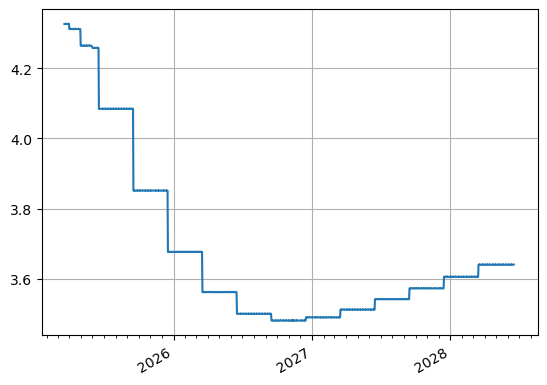

In [26]:
curve_sofr.plot("1b")

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1a423ba58d0>])

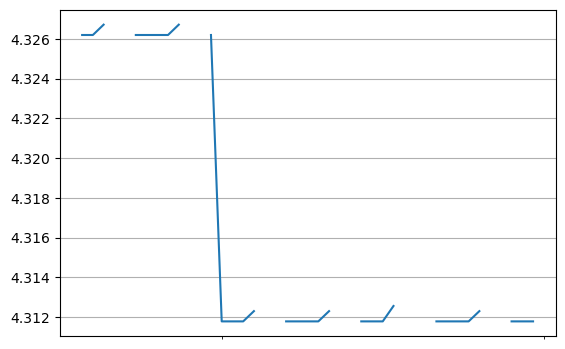

In [27]:
curve_sofr.plot("1b", right=dt(2025, 4, 30))

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1a423d4ab30>])

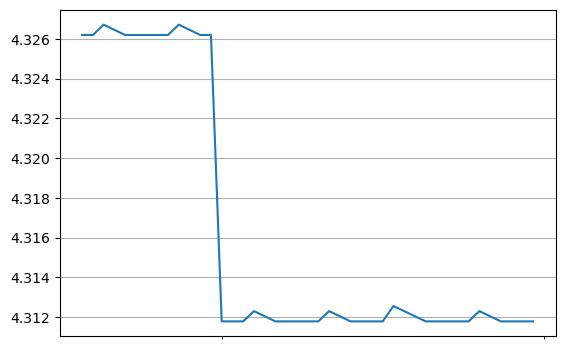

In [28]:
curve_sofr.plot("1d", right=dt(2025, 4, 30))

Rate plotted for the 21st (Friday) is the simple rate applicable between the 21st and 24th (Monday).

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1a423dbba90>])

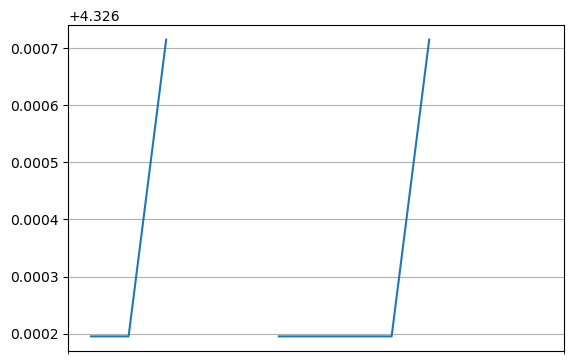

In [29]:
curve_sofr.plot("1b", right=dt(2025, 3, 31))

In [30]:
curve_sofr.rate(dt(2025, 3, 21), dt(2025, 3, 22)).real

4.326195119102039

In [31]:
nyc_cal = NamedCal("nyc")

In [32]:
nyc_cal.is_bus_day(dt(2025, 3, 22))

False

In [33]:
curve_sofr.rate(dt(2025, 3, 21), dt(2025, 3, 24)).real

4.326715027815453

In [34]:
daycount = dcf(dt(2025, 3, 21), dt(2025, 3, 24), "act360")
print(daycount)

0.008333333333333333


In [35]:
start_df = curve_sofr[dt(2025, 3, 21)].real
print(start_df)

0.9997596991437674


In [36]:
end_df = curve_sofr[dt(2025, 3, 24)].real
print(end_df)

0.9993993561260223


In [37]:
def rate_simple(start_df, end_df, daycount):
    return (start_df/end_df-1)*(1/daycount)*100

In [38]:
rate_simple(start_df, end_df, daycount)

4.326715027818118

Interpolated discount factor's continue to decrease linearly 

In [39]:
for date in nyc_cal.cal_date_range(dt(2025, 3, 19), dt(2025, 3, 26)):
    print(curve_sofr[date].real)

1.0
0.9998798423529536
0.9997596991437674
0.9996395703707064
0.9995194560320362
0.9993993561260223
0.9992792706509305
0.9991591996050269


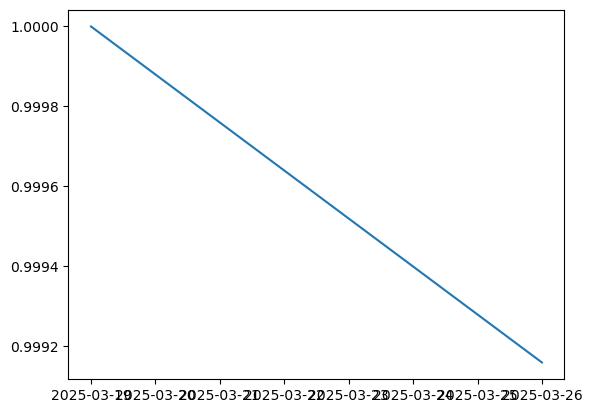

In [40]:
fig, ax = plt.subplots(1, 1)
x, y1 = [], []
for date in nyc_cal.cal_date_range(dt(2025, 3, 19), dt(2025, 3, 26)):
    x.append(date)
    y1.append(curve_sofr[date])
ax.plot(x, y1)

<span style="font-size: 18px;">SOFR IRS Curve</span>

In [41]:
curve_irs = Curve(
     nodes={
        dt(2025, 3, 19): 1.00,  # today's DF
        dt(2025, 3, 31): 1.00, #turn 1
        dt(2025, 4, 1): 1.00, #turn 1
        dt(2025, 5, 8): 1.00,  # defined effective FOMC dates..
        dt(2025, 6, 20): 1.00,
        dt(2025, 6, 30): 1.00, #turn 2
        dt(2025, 7, 1): 1.00, #turn 2
        dt(2025, 7, 31): 1.00,
        dt(2025, 9, 18): 1.00,
        dt(2025, 9, 30): 1.00, #turn 3
        dt(2025, 10, 1): 1.00, #turn 3
        dt(2025, 10, 30): 1.00,
        dt(2025, 12, 11): 1.00,
        dt(2025, 12, 31): 1.00, #turn 4
        dt(2026, 1, 2): 1.00, #turn 4
        dt(2026, 1, 29): 1.00,
        dt(2026, 3, 19): 1.00,
        dt(2026, 3, 31): 1.00, #turn 5
        dt(2026, 4, 1): 1.00, #turn 5
        dt(2026, 4, 30): 1.00,  
        dt(2026, 6, 18): 1.00,
        dt(2026, 6, 30): 1.00, #turn 6
        dt(2026, 7, 1): 1.00, #turn 6
        dt(2026, 7, 30): 1.00,
        dt(2026, 9, 17): 1.00,
        dt(2026, 9, 30): 1.00, #turn 7
        dt(2026, 10, 1): 1.00, #turn 7
        dt(2026, 10, 29): 1.00,
        dt(2026, 12, 10): 1.00,
        dt(2026, 12, 31): 1.00, #turn 8
        dt(2027, 1, 4): 1.00, #turn 8
        dt(2027, 1, 28): 1.00,
        dt(2027, 3, 18): 1.00, # estimated effective FOMC dates...
        dt(2027, 3, 31): 1.00, #turn 9
        dt(2027, 4, 1): 1.00, #turn 9
        dt(2027, 5, 6): 1.00,  
        dt(2027, 6, 17): 1.00,
        dt(2027, 6, 30): 1.00, #turn 10
        dt(2027, 7, 1): 1.00, #turn 10
        dt(2027, 7, 29): 1.00,
        dt(2027, 9, 16): 1.00,
        dt(2027, 9, 30): 1.00, #turn 11
        dt(2027, 10, 1): 1.00, #turn 11
        dt(2027, 11, 5): 1.00,
        dt(2027, 12, 16): 1.00,
        dt(2027, 12, 31): 1.00, #turn 12
        dt(2028, 1, 3): 1.00, #turn 12
        dt(2028, 1, 27): 1.00,
        dt(2028, 3, 9): 1.00,
        dt(2028, 3, 31): 1.00, #turn 13
        dt(2028, 4, 3): 1.00, #turn 13
        dt(2028, 4, 20): 1.00,
        dt(2028, 6, 21): 1.00,  # final IMM.
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [42]:
args_turn = dict(termination="1d", frequency="A", curves="irs")
args_fomc = dict(spec="usd_irs", curves="irs")
fomc_1 = IRS(dt(2025, 5, 8), dt(2025, 6, 20), **args_fomc)
fomc_2 = IRS(dt(2025, 6, 20), dt(2025, 7, 31), **args_fomc)
fomc_3 = IRS(dt(2025, 7, 31), dt(2025, 9, 18), **args_fomc)
fomc_4 = IRS(dt(2025, 9, 18), dt(2025, 10, 30), **args_fomc)
fomc_5 = IRS(dt(2025, 10, 30), dt(2025, 12, 11), **args_fomc)
fomc_6 = IRS(dt(2025, 12, 11), dt(2026, 1, 29), **args_fomc)
fomc_7 = IRS(dt(2026, 1, 29), dt(2026, 3, 19), **args_fomc)
fomc_8 = IRS(dt(2026, 3, 19), dt(2026, 4, 30), **args_fomc)
fomc_9 = IRS(dt(2026, 4, 30), dt(2026, 6, 18), **args_fomc)
fomc_10 = IRS(dt(2026, 6, 18), dt(2026, 7, 30), **args_fomc)
fomc_11 = IRS(dt(2026, 7, 30), dt(2026, 9, 17), **args_fomc)
fomc_12 = IRS(dt(2026, 9, 17), dt(2026, 10, 29), **args_fomc)
fomc_13 = IRS(dt(2026, 10, 29), dt(2026, 12, 10), **args_fomc)
fomc_14 = IRS(dt(2026, 12, 10), dt(2027, 1, 28), **args_fomc)
fomc_15 = IRS(dt(2027, 1, 28), dt(2027, 3, 18), **args_fomc)
fomc_16 = IRS(dt(2027, 3, 18), dt(2027, 5, 6), **args_fomc)
fomc_17 = IRS(dt(2027, 5, 6), dt(2027, 6, 17), **args_fomc)
fomc_18 = IRS(dt(2027, 6, 17), dt(2027, 7, 29), **args_fomc)
fomc_19 = IRS(dt(2027, 7, 29), dt(2027, 9, 16), **args_fomc)
fomc_20 = IRS(dt(2027, 9, 16), dt(2027, 11, 5), **args_fomc)
fomc_21 = IRS(dt(2027, 11, 5), dt(2027, 12, 16), **args_fomc)
fomc_22 = IRS(dt(2027, 12, 16), dt(2028, 1, 27), **args_fomc)
fomc_23 = IRS(dt(2028, 1, 27), dt(2028, 3, 9), **args_fomc)
fomc_24 = IRS(dt(2028, 3, 9), dt(2028, 4, 20), **args_fomc)
fomc_25 = IRS(dt(2028, 4, 20), dt(2028, 6, 21), **args_fomc)
turn_1a = IRS(effective=dt(2025, 3, 30), **args_turn)
turn_1b = IRS(effective=dt(2025, 3, 31), **args_turn)
turn_1c = IRS(effective=dt(2025, 4, 1), **args_turn)
turn_2a = IRS(effective=dt(2025, 6, 29), **args_turn)
turn_2b = IRS(effective=dt(2025, 6, 30), **args_turn)
turn_2c = IRS(effective=dt(2025, 7, 1), **args_turn)
turn_3a = IRS(effective=dt(2025, 9, 29), **args_turn)
turn_3b = IRS(effective=dt(2025, 9, 30), **args_turn)
turn_3c = IRS(effective=dt(2025, 10, 1), **args_turn)
turn_4a = IRS(effective=dt(2025, 12, 30), **args_turn)
turn_4b = IRS(effective=dt(2025, 12, 31), **args_turn)
turn_4c = IRS(effective=dt(2026, 1, 2), **args_turn)
turn_5a = IRS(effective=dt(2026, 3, 30), **args_turn)
turn_5b = IRS(effective=dt(2026, 3, 31), **args_turn)
turn_5c = IRS(effective=dt(2026, 4, 1), **args_turn)
turn_6a = IRS(effective=dt(2026, 6, 29), **args_turn)
turn_6b = IRS(effective=dt(2026, 6, 30), **args_turn)
turn_6c = IRS(effective=dt(2026, 7, 1), **args_turn)
turn_7a = IRS(effective=dt(2026, 9, 29), **args_turn)
turn_7b = IRS(effective=dt(2026, 9, 30), **args_turn)
turn_7c = IRS(effective=dt(2026, 10, 1), **args_turn)
turn_8a = IRS(effective=dt(2026, 12, 30), **args_turn)
turn_8b = IRS(effective=dt(2026, 12, 31), **args_turn)
turn_8c = IRS(effective=dt(2027, 1, 4), **args_turn)
turn_9a = IRS(effective=dt(2027, 3, 30), **args_turn)
turn_9b = IRS(effective=dt(2027, 3, 31), **args_turn)
turn_9c = IRS(effective=dt(2027, 4, 1), **args_turn)
turn_10a = IRS(effective=dt(2027, 6, 29), **args_turn)
turn_10b = IRS(effective=dt(2027, 6, 30), **args_turn)
turn_10c = IRS(effective=dt(2027, 7, 1), **args_turn)
turn_11a = IRS(effective=dt(2027, 9, 29), **args_turn)
turn_11b = IRS(effective=dt(2027, 9, 30), **args_turn)
turn_11c = IRS(effective=dt(2027, 10, 1), **args_turn)
turn_12a = IRS(effective=dt(2027, 12, 30), **args_turn)
turn_12b = IRS(effective=dt(2027, 12, 31), **args_turn)
turn_12c = IRS(effective=dt(2028, 1, 3), **args_turn)
turn_13a = IRS(effective=dt(2028, 3, 30), **args_turn)
turn_13b = IRS(effective=dt(2028, 3, 31), **args_turn)
turn_13c = IRS(effective=dt(2028, 4, 3), **args_turn)

In [43]:
args_irs = dict(spec="usd_irs", curves="irs")
instruments_irs = [
    IRS(dt(2025, 3, 1), dt(2025, 4, 1), leg2_fixings=defaults.fixings["sofr_1903"], **args_irs),
    IRS(dt(2025, 4, 1), dt(2025, 5, 1), **args_irs),
    IRS(dt(2025, 5, 1), dt(2025, 6, 1), **args_irs),
    IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs),
    IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs),
    Spread(turn_1a, turn_1b),
    Spread(turn_1b, turn_1c),
    Spread(turn_2a, turn_2b),
    Spread(turn_2b, turn_2c), 
    Spread(turn_3a, turn_3b),
    Spread(turn_3b, turn_3c),
    Spread(turn_4a, turn_4b),
    Spread(turn_4b, turn_4c),
    Spread(turn_5a, turn_5b),
    Spread(turn_5b, turn_5c),
    Spread(turn_6a, turn_6b),
    Spread(turn_6b, turn_6c),
    Spread(turn_7a, turn_7b),
    Spread(turn_7b, turn_7c), 
    Spread(turn_8a, turn_8b), 
    Spread(turn_8b, turn_8c),
    Spread(turn_9a, turn_9b),
    Spread(turn_9b, turn_9c),
    Spread(turn_10a, turn_10b), 
    Spread(turn_10b, turn_10c), 
    Spread(turn_11a, turn_11b),
    Spread(turn_11b, turn_11c),
    Spread(turn_12a, turn_12b),
    Spread(turn_12b, turn_12c), 
    Spread(turn_13a, turn_13b), 
    Spread(turn_13b, turn_13c),
    Fly(fomc_1, fomc_2, fomc_3),
    Fly(fomc_3, fomc_4, fomc_5),
    Fly(fomc_5, fomc_6, fomc_7),
    Fly(fomc_7, fomc_8, fomc_9),
    Fly(fomc_9, fomc_10, fomc_11),
    Fly(fomc_11, fomc_12, fomc_13),
    Fly(fomc_13, fomc_14, fomc_15),
    Fly(fomc_15, fomc_16, fomc_17),
    Fly(fomc_17, fomc_18, fomc_19),
    Fly(fomc_19, fomc_20, fomc_21),
    Fly(fomc_21, fomc_22, fomc_23),
    Fly(fomc_23, fomc_24, fomc_25),
]

 Convexity adjustment calculation used is shown in Convx Adj hw.ipynb

In [44]:
convx_adj = [0, -0.00003, -0.00017, -0.00001, -0.00098, -0.00258, -0.00481, -0.00764, -0.01107, -0.01508, -0.01966, -0.02479, -0.03046, -0.03666, 
             -0.04337, -0.05116]
s_adj = [
 inst.rate(solver=solver_sofr, curves="sofr").real + convx_adj for (inst,convx_adj) in zip(instruments_irs[:16], convx_adj)
]
print(s_adj)

[4.3313282725389675, 4.319256403107015, 4.271869139561201, 4.310690941960031, 4.104430942863949, 3.867378944631851, 3.688792947217207, 3.5702849505491385, 3.5045829545489706, 3.4811409591316353, 3.48556296420856, 3.502881969688859, 3.527125975481564, 3.552121981496469, 3.5786259876445263, 3.607046993369971]


In [45]:
s_irs = s_adj + [5, -5] * 13 + [0] * 12

In [46]:
weights_irs = [1] * 16 + [1e-09] * 2 + [1] * 24 + [1e-09] * 12 #Includes low weighting for first turn to favor mkt instruments 

In [47]:
instrument_labels_irs = [
    "1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8", "turn1_left", "turn1_right", 
    "turn2_left", "turn2_right", "turn3_left", "turn3_right", "turn4_left", "turn4_right", "turn5_left", "turn5_right", "turn6_left", 
    "turn6_right", "turn7_left", "turn7_right", "turn8_left", "turn8_right", "turn9_left", "turn9_right", "turn10_left", "turn10_right",
    "turn11_left", "turn11_right", "turn12_left", "turn12_right", "turn13_left", "turn13_right", "cv1", "cv2", "cv3", "cv4", "cv5", "cv6", 
    "cv7", "cv8", "cv9", "cv10", "cv11", "cv12",
]

In [48]:
solver_irs = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_irs],
    instruments=instruments_irs,
    s=s_irs,
    weights=weights_irs,
    instrument_labels=instrument_labels_irs,
    func_tol=1e-08,  
    conv_tol=1e-10,
    id="irs",
)

SUCCESS: `conv_tol` reached after 13 iterations (levenberg_marquardt), `f_val`: 1.1946456424225436e-06, `time`: 0.6934s


In [49]:
for inst in instruments_irs:
    print(inst.rate(solver=solver_irs).real)

4.331612661792906
4.319506813088214
4.27238386624465
4.3098046746771335
4.104430942862975
3.8673789446306936
3.688792947216183
3.570284950547883
3.5045829545480824
3.4811409591306504
3.4855629642072214
3.502881969688656
3.5271259754791906
3.5521219814974394
3.578625987642043
3.6070469933694254
4.453161238160419
-5.592408601806653
5.000000000432436
-5.000000000432525
5.000000000432481
-5.000000000432481
4.999999998833715
-4.999999999632987
4.999999999633076
-4.99999999963312
5.000000000432525
-4.999999998833671
4.99999999963312
-4.999999998833804
5.000000000432481
-5.000000001231797
4.9999999996331645
-5.000000000432436
4.999999999632987
-4.99999999963312
4.999999998833804
-4.9999999996331645
4.999999999633031
-4.999999999633076
4.99999999963312
-5.000000001231797
-3.625748590252442e-08
6.534088825560502e-08
-1.5608736525507538e-07
2.903143059285185e-07
-4.6522261598624937e-07
3.1022793223201006e-07
3.2636751079451187e-07
-2.080985606056629e-06
3.609150800443217e-06
-5.866858376890605e-

In [50]:
with pd.option_context('display.max_rows', None):
    print(solver_irs.error)

sofr  1H5             1.955236e-09
      1J5             1.942979e-09
      1K5             2.254996e-09
      H5             -5.803997e-06
      M5             -5.713605e-06
      U5             -5.536815e-06
      Z5             -5.278279e-06
      H6             -4.945086e-06
      M6             -4.545103e-06
      U6             -4.086836e-06
      Z6             -3.579144e-06
      H7             -3.031114e-06
      M7             -2.451844e-06
      U7             -1.850353e-06
      Z7             -1.235547e-06
      H8             -6.630029e-07
irs   1H5             2.843893e-02
      1J5             2.504100e-02
      1K5             5.147267e-02
      H5             -8.862673e-02
      M5             -9.743317e-11
      U5             -1.157296e-10
      Z5             -1.024070e-10
      H6             -1.255440e-10
      M6             -8.881784e-11
      U6             -9.849899e-11
      Z6             -1.338485e-10
      H7             -2.029488e-11
      M7            

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x1a4216ac6d0>])

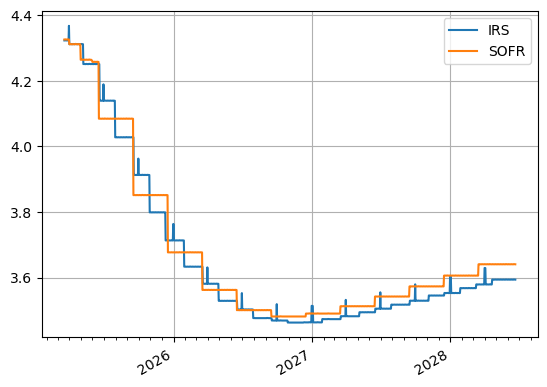

In [51]:
curve_irs.plot("1d", comparators=[curve_sofr], labels=["IRS", "SOFR"])

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 [<matplotlib.lines.Line2D at 0x1a423e02950>])

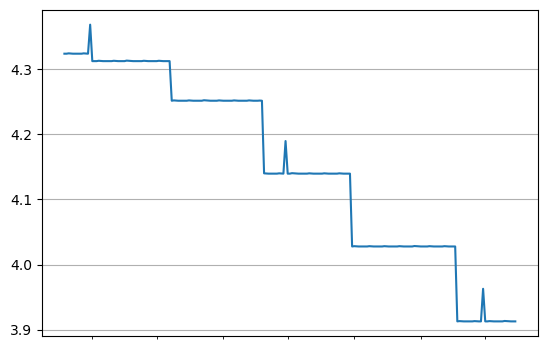

In [52]:
curve_irs.plot("1d", left=dt(2025, 3, 19), right=dt(2025, 10, 15))

In [53]:
irs_m5 = IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs)

In [54]:
irs_m5.rate(solver=solver_irs)

<Dual: 4.104431, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>

In [55]:
irs_2y = IRS(dt(2025, 3, 21), "2Y", **args_irs)

In [56]:
irs_2y.rate(solver=solver_irs)

<Dual: 3.806572, (irs0, irs1, irs2, ...), [43.5, 8.7, 0.0, ...]>

In [57]:
m5.rate(solver=solver_irs)

<Dual: 4.105411, (sofr0, sofr1, sofr2, ...), [0.0, 0.0, 0.0, ...]>

In [58]:
irs_2y.npv(solver=solver_irs)

<Dual: 0.000000, (irs0, irs1, irs2, ...), [832967.5, 166833.7, 0.0, ...]>

In [59]:
irs_2y.cashflows(curves=curve_irs)

Type   Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod  Regular  USD 2025-03-21 2026-03-23 2026-03-25     act360   
     1  FixedPeriod  Regular  USD 2026-03-23 2027-03-22 2027-03-24     act360   
leg2 0  FloatPeriod  Regular  USD 2025-03-21 2026-03-23 2026-03-25     act360   
     1  FloatPeriod  Regular  USD 2026-03-23 2027-03-22 2027-03-24     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  1.019444  1000000.0  0.959959       None  3.806572     NaN   
     1  1.011111  1000000.0  0.926649       None  3.806572     NaN   
leg2 0  1.019444 -1000000.0  0.959959       None  4.046655     0.0   
     1  1.011111 -1000000.0  0.926649       None  3.555809     0.0   

            Cashflow           NPV  FX Rate       NPV Ccy  
leg1 0 -38805.890862 -37252.079875      1.0 -37252.079875  
     1 -38488.676495 -35665.482708      1.0 -35665.482708  
leg2 0  41253.402377  39601.591570      1.0  39601.591570  
     1  35953.183108  33315.971012      1.0  33315.971012

In [60]:
irs_2y.cashflows_table(curves=curve_irs)

local_ccy,USD
collateral_ccy,NaN
payment,
2026-03-25,2447.511515
2027-03-24,-2535.493388


In [61]:
defaults.spec["usd_irs"]

{'frequency': 'a',
 'stub': 'shortfront',
 'eom': False,
 'modifier': 'mf',
 'calendar': 'nyc',
 'payment_lag': 2,
 'currency': 'usd',
 'convention': 'act360',
 'leg2_spread_compound_method': 'none_simple',
 'leg2_fixing_method': 'rfr_payment_delay',
 'leg2_method_param': 0}

In [62]:
irs_2y.analytic_delta(curve_irs)

<Dual: 191.557010, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>

In [63]:
irs_m5.delta(solver=solver_irs).style.format("{:,.2f}")

In [64]:
m5.delta(solver=solver_irs).style.format("{:,.2f}")

<span style="font-size: 18px;">Risk framework intended to highlight exposure to convexity parameter</span>
https://rateslib.com/py/en/2.0.x/z_convexityrisk.html#

In [65]:
curve_full = Curve(
    nodes={
        dt(2025, 3, 19): 1.0,
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.0,
        dt(2025, 12, 17): 1.0,
        dt(2026, 3, 18): 1.0,
        dt(2026, 6, 17): 1.0,
        dt(2026, 9, 16): 1.0,
        dt(2026, 12, 16): 1.0,
        dt(2027, 3, 17): 1.0,
        dt(2027, 6, 16): 1.0,
        dt(2027, 9, 15): 1.0,
        dt(2027, 12, 15): 1.0,
        dt(2028, 3, 15): 1.0,
        dt(2028, 6, 21): 1.0,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [66]:
instruments_full = [
    Spread(sofr_futures[3], IRS(effective=get_imm(code="H25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[4], IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[5], IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[6], IRS(effective=get_imm(code="Z25"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[7], IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[8], IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[9], IRS(effective=get_imm(code="U26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[10], IRS(effective=get_imm(code="Z26"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[11], IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[12], IRS(effective=get_imm(code="M27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[13], IRS(effective=get_imm(code="U27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[14], IRS(effective=get_imm(code="Z27"), termination="3m", roll="imm", **args_irs)),
    Spread(sofr_futures[15], IRS(effective=get_imm(code="H28"), termination="3m", roll="imm", **args_irs)),
]

In [67]:
"""
This method does not give the proper instrument rate for equivalent 1-month IRS due to pricing as a spread off of the arithmetic average 1-month 
futures rate. 
"""
s_full = [adj *100 for adj in convx_adj[3:]] 
print(s_full)

[-0.001, -0.098, -0.258, -0.481, -0.764, -1.107, -1.508, -1.966, -2.479, -3.0460000000000003, -3.666, -4.337, -5.116]


In [68]:
instrument_labels_full = [
    "IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8",
]

In [69]:
solver_full = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_full],
    instruments=instruments_full,
    s=s_full,
    instrument_labels=instrument_labels_full,
    id="full",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 3.0260389079725514e-22, `time`: 0.0557s


(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
  <matplotlib.lines.Line2D at 0x1a425022b30>])

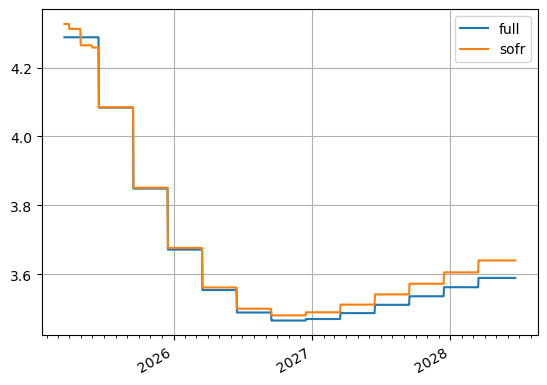

In [70]:
curve_full.plot("1d", comparators=[curve_sofr], labels=["full", "sofr"]) 

In [71]:
m5.delta(solver=solver_full).style.format("{:,.2f}")

In [72]:
m5_imm = IRS(effective=get_imm(code="M25"), termination="3m", roll="imm", spec="usd_irs", curves="irs")

In [73]:
m5_imm.delta(solver=solver_full).style.format("{:,.2f}")

Portfolio of payer IRS hedged with long future (negative gamma) 

In [74]:
pf_full = Portfolio([m5, m5_imm])

Comparing IMM risk buckets highlights hedged delta and exposure to convexity adjustment 

In [75]:
pf_full.delta(solver=solver_full).style.format("{:,.2f}")

In [76]:
pf_full.gamma(solver=solver_full).sum().sum()

-0.010010860588066677

Portfolio cross gamma grid

In [77]:
pf_full.gamma(solver=solver_full).style.format("{:,.5f}")

Fixings table showing example turn risk

In [78]:
sep_turn = IRS(effective=dt(2025, 9, 30), termination="1d", frequency="A", curves="irs", notional=-1e9)

In [79]:
sep_turn.fixings_table(curves=curve_full, solver=solver_full).style.format("{:,.2f}")

<span style="font-size: 18px;">Forward risk model for PnL calculations</span>

In [80]:
curve_fwd = Curve(
     nodes={
        dt(2025, 3, 19): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,  
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [81]:
instruments_fwd = instruments_irs[3:16]

In [82]:
s_fwd = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_fwd)
]

In [83]:
solver_fwd = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_fwd],
    instruments=instruments_fwd,
    s=s_fwd,
    instrument_labels=["IMM H5", "IMM M5", "IMM U5", "IMM Z5", "IMM H6", "IMM M6", "IMM U6", "IMM Z6", "IMM H7", "IMM M7", "IMM U7", "IMM Z7", "IMM H8"],
    id="fwd",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 2.208840112108169e-14, `time`: 0.0481s


In [84]:
for instrument in instruments_fwd:
    print(float(instrument.rate(solver=solver_fwd)))

4.3098046165398145
4.104430885626912
3.867378889164118
3.688792894337689
3.570284901005096
3.5045829090096516
3.481140918180902
3.485562928341493
3.5028819393115485
3.5271259509048254
3.552121962949199
3.578625975255028
3.6070469867212736


In [85]:
irs_1y = IRS(dt(2025, 3, 21), "1Y", spec="usd_irs_lt_2y", curves="irs")

In [86]:
irs_1y.delta(solver=solver_fwd).style.format("{:,.2f}")

In [87]:
m5.delta(solver=solver_fwd).style.format("{:,.2f}")

In [88]:
m5_imm.delta(solver=solver_fwd).style.format("{:,.2f}")

In [89]:
pf_full.delta(solver=solver_fwd).style.format("{:,.2f}")

<span style="font-size: 18px;;">Par risk model</span>

In [90]:
curve_par = Curve(
      nodes={
        dt(2025, 3, 19): 1.00,  
        dt(2025, 6, 18): 1.00,
        dt(2025, 9, 17): 1.00,
        dt(2025, 12, 17): 1.00,
        dt(2026, 3, 18): 1.00, 
        dt(2026, 6, 17): 1.00,
        dt(2026, 9, 16): 1.00,
        dt(2026, 12, 16): 1.00,
        dt(2027, 3, 17): 1.00,  
        dt(2027, 6, 16): 1.00,
        dt(2027, 9, 15): 1.00,
        dt(2027, 12, 15): 1.00,
        dt(2028, 3, 15): 1.00,
        dt(2028, 6, 21): 1.00,
    },
    interpolation="log_linear",
    calendar="nyc",
    convention="act360",
    modifier="MF",
    id="irs",
)

In [91]:
instruments_par = [
    IRS(dt(2025, 3, 21), "3M", spec="usd_irs_lt_2y", curves="irs"), #+2 effective date  
    IRS(dt(2025, 3, 21), "6M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "9M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "1Y", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "15M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "18M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "21M", spec="usd_irs_lt_2y", curves="irs"),
    IRS(dt(2025, 3, 21), "2Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "27M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "30M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "33M", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "3Y", spec="usd_irs", curves="irs"),
    IRS(dt(2025, 3, 21), "39M", spec="usd_irs", curves="irs"),
]

In [92]:
s_par = [
 instrument.rate(solver=solver_irs).real for (instrument) in (instruments_par)
]

In [93]:
solver_par = Solver(
    pre_solvers=[solver_sofr],
    curves=[curve_par],
    instruments=instruments_par,
    s=s_par,
    instrument_labels=["3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"],
    id="par",
)

SUCCESS: `func_tol` reached after 4 iterations (levenberg_marquardt), `f_val`: 1.3553943117797705e-12, `time`: 0.0450s


In [94]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_irs)))

4.304269612429162
4.221804099196816
4.128448296942771
4.046655274003683
3.9487317633657195
3.881545534454866
3.8359086532093647
3.8065724006395127
3.772082683048111
3.7517609329932453
3.740932780585428
3.736915960385348
3.726050401653832


In [95]:
for instrument in instruments_par:
    print(float(instrument.rate(solver=solver_par)))

4.30426960899897
4.221804100303823
4.128448299522592
4.046655282949311
3.9487317806093047
3.8815455384690587
3.83590865905176
3.806572405776925
3.7720826677591033
3.7517607775549364
3.7409324716595966
3.7369153517276783
3.7260494718008816


In [96]:
for instrument in instruments_par:
    print(instrument.cashflows(curve_irs))

               Type Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod   Stub  USD 2025-03-21 2025-06-23 2025-06-25     act360   
leg2 0  FloatPeriod   Stub  USD 2025-03-21 2025-06-23 2025-06-25     act360   

             DCF   Notional        DF Collateral     Rate  Spread  \
leg1 0  0.261111  1000000.0  0.988421       None  4.30427     NaN   
leg2 0  0.261111 -1000000.0  0.988421       None  4.30427     0.0   

           Cashflow           NPV  FX Rate       NPV Ccy  
leg1 0 -11238.92621 -11108.792797      1.0 -11108.792797  
leg2 0  11238.92621  11108.792797      1.0  11108.792797  
               Type Period  Ccy  Acc Start    Acc End    Payment Convention  \
leg1 0  FixedPeriod   Stub  USD 2025-03-21 2025-09-22 2025-09-24     act360   
leg2 0  FloatPeriod   Stub  USD 2025-03-21 2025-09-22 2025-09-24     act360   

             DCF   Notional        DF Collateral      Rate  Spread  \
leg1 0  0.513889  1000000.0  0.978318       None  4.221804     NaN   

Forward to par jacobian showing risk to input instrument columns for scaled 1bp movement of row instruments 

In [97]:
solver_fwd.jacobian(solver_par).style.format("{:,.2f}")

In [98]:
solver_par.jacobian(solver_fwd).style.format("{:,.2f}")

Testing lossless transformation to shown precision 

In [99]:
pd.DataFrame(solver_par.jacobian(solver_fwd) - np.linalg.inv(solver_fwd.jacobian(solver_par))).style.format("{:,.2f}")

In [100]:
pd.DataFrame(solver_fwd.jacobian(solver_par) - np.linalg.inv(solver_par.jacobian(solver_fwd))).style.format("{:,.2f}")

Testing lossless by converting forward risk to par risk and then reversing transformation 

In [101]:
fwd_risk = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000, 0, 0, 0])[:, np.newaxis]
par_risk = np.matmul(solver_fwd.jacobian(solver_par), fwd_risk)
par_risk.style.format("{:,.2f}")

In [102]:
fwd_risk_reversed = np.matmul(solver_par.jacobian(solver_fwd), par_risk)
fwd_risk_reversed.style.format("{:,.2f}")

In [103]:
m5.delta(solver=solver_par).style.format("{:,.2f}")

In [104]:
m5_imm.delta(solver=solver_par).style.format("{:,.2f}")

In [105]:
pf_full.delta(solver=solver_par).style.format("{:,.2f}")

<span style="font-size: 18px;">Custom risk model</span>

Creates benchmark instrument combinations from par model. Matrix represents model to par jacobian. Inverse represents par to model jacobian. 

6M, 2Y, 1Y/2Y, 1Y/2Y/3Y, 3M/1Y, 3M/6M/9M, 18M, 15M/18M, 18M/21M, 27M/30M, 30M/33M, 33M/3Y, 3Y/39M

In [106]:
matrix = np.array([
    [1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0], 
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1, -1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1,  0],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1, -1],
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
])

try:
    inverse_matrix = np.linalg.inv(matrix)
except np.linalg.LinAlgError:
    print("The matrix is singular and cannot be inverted.")

IMM swap rates proxied by futures data for example purposes

See README in data folder 

In [107]:
historical_prices = pd.read_csv("Data/back_adjusted_sofr_rates0319.csv", index_col=0, parse_dates=True)

In [108]:
historical_prices

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-18,95.6300,95.5825,95.795,95.9125,96.055,96.055,96.080,96.135,96.190,96.210,...,96.080,96.135,96.190,96.210,96.210,96.215,96.215,96.220,96.220,96.220
2024-03-19,95.6300,95.5825,95.795,95.9125,96.075,96.075,96.110,96.180,96.250,96.280,...,96.110,96.180,96.250,96.280,96.280,96.285,96.280,96.280,96.275,96.275
2024-03-20,95.6300,95.5825,95.815,95.9225,96.130,96.165,96.215,96.285,96.350,96.365,...,96.215,96.285,96.350,96.365,96.350,96.345,96.335,96.330,96.315,96.310
2024-03-21,95.6300,95.5825,95.810,95.9175,96.110,96.150,96.190,96.255,96.315,96.335,...,96.190,96.255,96.315,96.335,96.335,96.335,96.325,96.320,96.310,96.305
2024-03-22,95.6300,95.5825,95.815,95.9225,96.130,96.170,96.215,96.285,96.355,96.385,...,96.215,96.285,96.355,96.385,96.390,96.395,96.390,96.385,96.370,96.360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,95.6725,95.6900,95.750,95.7000,95.935,96.180,96.320,96.405,96.440,96.445,...,96.320,96.405,96.440,96.445,96.430,96.400,96.370,96.340,96.310,96.275
2025-03-13,95.6725,95.6900,95.765,95.7075,95.960,96.210,96.360,96.450,96.490,96.495,...,96.360,96.450,96.490,96.495,96.480,96.455,96.425,96.395,96.365,96.330
2025-03-14,95.6750,95.6900,95.755,95.7000,95.930,96.145,96.280,96.365,96.405,96.415,...,96.280,96.365,96.405,96.415,96.410,96.390,96.365,96.340,96.310,96.275


In [109]:
historical_rates = 100 - historical_prices

In [110]:
historical_rates

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,...,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,
2024-03-18,4.3700,4.4175,4.205,4.0875,3.945,3.945,3.920,3.865,3.810,3.790,...,3.920,3.865,3.810,3.790,3.790,3.785,3.785,3.780,3.780,3.780
2024-03-19,4.3700,4.4175,4.205,4.0875,3.925,3.925,3.890,3.820,3.750,3.720,...,3.890,3.820,3.750,3.720,3.720,3.715,3.720,3.720,3.725,3.725
2024-03-20,4.3700,4.4175,4.185,4.0775,3.870,3.835,3.785,3.715,3.650,3.635,...,3.785,3.715,3.650,3.635,3.650,3.655,3.665,3.670,3.685,3.690
2024-03-21,4.3700,4.4175,4.190,4.0825,3.890,3.850,3.810,3.745,3.685,3.665,...,3.810,3.745,3.685,3.665,3.665,3.665,3.675,3.680,3.690,3.695
2024-03-22,4.3700,4.4175,4.185,4.0775,3.870,3.830,3.785,3.715,3.645,3.615,...,3.785,3.715,3.645,3.615,3.610,3.605,3.610,3.615,3.630,3.640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,4.3275,4.3100,4.250,4.3000,4.065,3.820,3.680,3.595,3.560,3.555,...,3.680,3.595,3.560,3.555,3.570,3.600,3.630,3.660,3.690,3.725
2025-03-13,4.3275,4.3100,4.235,4.2925,4.040,3.790,3.640,3.550,3.510,3.505,...,3.640,3.550,3.510,3.505,3.520,3.545,3.575,3.605,3.635,3.670
2025-03-14,4.3250,4.3100,4.245,4.3000,4.070,3.855,3.720,3.635,3.595,3.585,...,3.720,3.635,3.595,3.585,3.590,3.610,3.635,3.660,3.690,3.725


In [111]:
# Compute daily rate changes in basis points (today - yesterday)
historical_chgs = historical_rates.diff() * 100

historical_chgs.style.format("{:,.1f}")

,SR1.c.0,SR1.c.1,SR1.c.2,1F,2F,3F,4F,5F,6F,7F,8F,9F,10F,11F,12F,13F,IMM1,IMM2,IMM3,IMM4,IMM5,IMM6,IMM7,IMM8,IMM9,IMM10,IMM11,IMM12,IMM13
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-18 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2024-03-19 00:00:00,0.0,0.0,0.0,0.0,-2.0,-2.0,-3.0,-4.5,-6.0,-7.0,-7.0,-7.0,-6.5,-6.0,-5.5,-5.5,0.0,-2.0,-2.0,-3.0,-4.5,-6.0,-7.0,-7.0,-7.0,-6.5,-6.0,-5.5,-5.5
2024-03-20 00:00:00,0.0,0.0,-2.0,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5,-1.0,-5.5,-9.0,-10.5,-10.5,-10.0,-8.5,-7.0,-6.0,-5.5,-5.0,-4.0,-3.5
2024-03-21 00:00:00,0.0,0.0,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5,0.5,2.0,1.5,2.5,3.0,3.5,3.0,1.5,1.0,1.0,1.0,0.5,0.5
2024-03-22 00:00:00,0.0,0.0,-0.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5,-0.5,-2.0,-2.0,-2.5,-3.0,-4.0,-5.0,-5.5,-6.0,-6.5,-6.5,-6.0,-5.5
2024-03-25 00:00:00,0.2,0.5,1.0,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5,0.5,2.0,3.0,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,3.5,3.5
2024-03-26 00:00:00,0.0,-0.5,-0.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5,-0.5,0.5,1.5,1.5,1.0,0.5,0.0,-1.0,-1.5,-2.0,-2.5,-2.5,-2.5
2024-03-27 00:00:00,0.2,0.2,0.0,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5,0.0,0.0,-1.0,-2.0,-2.5,-3.5,-4.0,-4.0,-4.5,-4.5,-4.5,-4.5,-4.5
2024-03-28 00:00:00,-0.2,-0.2,0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5,0.2,2.0,4.5,5.5,6.0,6.0,5.5,4.5,3.5,2.0,1.0,0.0,-0.5


In [112]:
Q = historical_chgs.cov().to_numpy()
Q

array([[ 0.24050129,  0.49134316,  0.56318575,  0.61260118,  0.70293627,
         0.62084796,  0.47907181,  0.35224183,  0.24364249,  0.16645126,
         0.11565445,  0.08736878,  0.07405695,  0.06824883,  0.06293872,
         0.05221772,  0.61260118,  0.70293627,  0.62084796,  0.47907181,
         0.35224183,  0.24364249,  0.16645126,  0.11565445,  0.08736878,
         0.07405695,  0.06824883,  0.06293872,  0.05221772],
       [ 0.49134316,  1.68932504,  2.27346368,  2.88744229,  3.97959155,
         4.11563073,  3.75354534,  3.30104186,  2.88263415,  2.54548275,
         2.27805247,  2.06415212,  1.89067144,  1.77703274,  1.6733542 ,
         1.56834369,  2.88744229,  3.97959155,  4.11563073,  3.75354534,
         3.30104186,  2.88263415,  2.54548275,  2.27805247,  2.06415212,
         1.89067144,  1.77703274,  1.6733542 ,  1.56834369],
       [ 0.56318575,  2.27346368,  3.9843918 ,  5.18438943,  8.31781999,
         9.43153181,  9.26249763,  8.60763296,  7.88258474,  7.26007478,
  

In [113]:
#Covariance matrix for par model 
inv_fwd = np.linalg.inv(solver_fwd.jacobian(solver_par))
inv_fwd_T = inv_fwd.T
Q_par = np.matmul(np.matmul(inv_fwd_T, Q), inv_fwd)

In [114]:
Q_par

array([[ 0.24050129,  0.49134316,  0.56318575,  0.61260118,  0.70293627,
         0.62084796,  0.47907181,  0.35224183,  0.24364249,  0.16645126,
         0.11565445,  0.08736878,  0.07405695,  0.06824883,  0.06293872,
         0.05221772,  0.61762891,  0.66447717,  0.65624818,  0.61888633,
         0.56303488,  0.51100057,  0.4648016 ,  0.42485194,  0.38693483,
         0.35656215,  0.33246134,  0.31242603,  0.2921382 ],
       [ 0.49134316,  1.68932504,  2.27346368,  2.88744229,  3.97959155,
         4.11563073,  3.75354534,  3.30104186,  2.88263415,  2.54548275,
         2.27805247,  2.06415212,  1.89067144,  1.77703274,  1.6733542 ,
         1.56834369,  2.94661522,  3.49593001,  3.74582137,  3.79705231,
         3.68693177,  3.56100702,  3.4356223 ,  3.31673773,  3.17451695,
         3.05187936,  2.94972341,  2.86121766,  2.76057712],
       [ 0.56318575,  2.27346368,  3.9843918 ,  5.18438943,  8.31781999,
         9.43153181,  9.26249763,  8.60763296,  7.88258474,  7.26007478,
  

In [115]:
#Covariance matrix for custom model 
inv_invmatrix = np.linalg.inv(inverse_matrix)
inv_invmatrix_T = inv_invmatrix.T
Q_mod = np.matmul(np.matmul(inv_invmatrix_T, Q_par), inv_invmatrix)

In [116]:
Q_mod

array([[ 2.40501288e-01,  4.91343159e-01,  5.63185749e-01,
         6.12601183e-01,  7.02936271e-01,  6.20847957e-01,
         4.79071808e-01,  3.52241826e-01,  2.43642494e-01,
         1.66451258e-01,  1.15654446e-01,  8.73687789e-02,
         7.40569468e-02,  6.82488301e-02,  6.29387213e-02,
         5.22177164e-02,  6.64477171e-01,  4.24851939e-01,
        -1.94034387e-01, -8.16084827e-02,  1.25741765e-03,
         5.50772516e-02,  5.11000568e-01, -5.20343098e-02,
        -4.61989644e-02, -3.03726783e-02, -2.41008036e-02,
        -2.00353088e-02, -2.02878385e-02],
       [ 4.91343159e-01,  1.68932504e+00,  2.27346368e+00,
         2.88744229e+00,  3.97959155e+00,  4.11563073e+00,
         3.75354534e+00,  3.30104186e+00,  2.88263415e+00,
         2.54548275e+00,  2.27805247e+00,  2.06415212e+00,
         1.89067144e+00,  1.77703274e+00,  1.67335420e+00,
         1.56834369e+00,  3.49593001e+00,  3.31673773e+00,
        -4.80314582e-01, -2.47945133e-02,  8.50437089e-01,
         2.99

Sample portfolio showing various instrument customizations 

In [117]:
portfolio = Portfolio([
    # Par swaps 
    IRS(effective=dt(2025, 3, 21), termination="1M", spec="usd_irs_lt_2y", curves="irs", notional=10e6), # Payer
    IRS(effective=dt(2025, 3, 21), termination="2M", spec="usd_irs_lt_2y", curves="irs", notional=-10e6), # Receiver
    IRS(effective=dt(2025, 3, 21), termination="1W", spec="usd_irs_lt_2y", curves="irs", notional=15e6),
    IRS(effective=dt(2025, 3, 21), termination="3W", spec="usd_irs_lt_2y", curves="irs", notional=-15e6),
    IRS(effective=dt(2025, 3, 21), termination="3M", spec="usd_irs_lt_2y", curves="irs", notional=250e6),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=200e6),
    IRS(effective=dt(2025, 3, 21), termination="6M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6),
    IRS(effective=dt(2025, 3, 21), termination="9M", spec="usd_irs_lt_2y", curves="irs", notional=-150e6),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6),
    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=-80e6),
    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=-60e6),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=30e6),
    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6),

    IRS(effective=dt(2025, 3, 21), termination="18M", spec="usd_irs_lt_2y", curves="irs", notional=50e6,  
        frequency="Q", amortization=10e6),  # Quarterly payments, reduce notional by 10M each quarter    

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=40e6, 
        frequency="Q", amortization=5e6),  

    IRS(effective=dt(2025, 3, 21), termination="3Y", spec="usd_irs", curves="irs", notional=-20e6,  
        frequency="Q", amortization=-2e6), # Negative amortization reduces notional on receiver 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=100e6, 
        frequency="Q", leg2_frequency="S", # Fixed leg quarterly amortizes, float leg semiannual with larger step amortization to align notionals.
        amortization=12.5e6, leg2_amortization=-25e6), # fixed leg: reduce 12.5M each quarter, float leg: reduce 25M each semiannual period    

    IRS(effective=dt(2025, 3, 21), termination="1Y", spec="usd_irs_lt_2y", curves="irs", notional=100e6, 
        leg2_float_spread=90.573756), # Equates to fixed rate of 4.95 

    IRS(effective=dt(2025, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-100e6, 
        leg2_float_spread=20.196949), # Equates to fixed rate of 4.00

    IRS(effective=dt(2025, 3, 21), termination="26M", spec="usd_irs", curves="irs", notional=40e6, 
        frequency="Q", stub="LONGBACK"),  # Creates a 2yr 2mo swap where the last accrual period is extended as a long stub.

    IRS(effective=dt(2025, 3, 21), termination="15M", spec="usd_irs_lt_2y", curves="irs", notional=70e6, 
        roll=15, stub="SHORTFRONT"), # Period start dates as of the 15th with short front stub

    IRS(effective=dt(2025, 3, 21), termination="21M", spec="usd_irs_lt_2y", curves="irs", notional=50e6, 
        stub="SHORTBACK"),

    IRS(effective=dt(2025, 3, 21), termination="30M", spec="usd_irs", curves="irs", notional=35e6, 
        roll="eom", leg2_frequency="S"), # End of month roll with semi annual floating leg 

    IRS(effective=dt(2025, 3, 21), termination="33M", spec="usd_irs", curves="irs", notional=-20e6, 
        roll="imm", leg2_frequency="Q"), # Aligns floating leg to IMM dates 

    # Forward-starting swaps 
    IRS(effective=dt(2025, 6, 21), termination="1Y", spec="usd_irs", curves="irs", notional=80e6), # 3M forward-starting, 1Y tenor swap,   
    IRS(effective=dt(2025, 9, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-90e6), 

    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=60e6, 
        leg2_convention="actact"), # Actual actual floating leg convention.

    IRS(effective=dt(2025, 12, 21), termination="1Y", spec="usd_irs", curves="irs", notional=70e6, 
        convention="actact", leg2_convention="30360"), # Fixed leg actual actual, floating leg 30360 convention.

    IRS(effective=dt(2025, 12, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6),
    IRS(effective=dt(2026, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-75e6),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=dt(2027, 3, 21), termination="6M", spec="usd_irs", curves="irs", notional=-25e6),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=20e6),
    IRS(effective=dt(2025, 9, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-50e6),
    IRS(effective=dt(2026, 3, 21), termination="2Y", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=dt(2027, 3, 21), termination="1Y", spec="usd_irs", curves="irs", notional=-15e6),

    # IMM swaps
    IRS(effective=get_imm(code="U25"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=50e6),
    IRS(effective=get_imm(code="H26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=-30e6),
    IRS(effective=get_imm(code="M26"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=30e6),
    IRS(effective=get_imm(code="H27"), termination="3m", roll="imm", spec="usd_irs", curves="irs", notional=20e6),
])

Variance-covariance risk functions adapted from: https://github.com/attack68/book_irds3/blob/main/bookirds/covar.py

In [118]:
def covar(Q, S=None, alpha: float=None):
    if S is None:
        S = portfolio.delta(solver=solver_par).to_numpy()
    c = np.sqrt(np.matmul(S.T, np.matmul(Q, S)))
    if alpha is not None:
        return norm.ppf(1 - alpha) * c
    return c

*Single instrument* minimising trade

In [119]:
def covar_smt(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        Q_inv = np.diag(-1 / np.diagonal(Q))
        return np.matmul(Q_inv, np.matmul(Q, S))

In [120]:
def covar_smt_impact(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_trade = covar_smt(Q, S)
        S_min = S + np.diag(S_trade[:, 0])  
        c_impact = np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min))) - c
        return np.diagonal(c_impact)[:, np.newaxis]

In [121]:
def covar_alloc(Q, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q, S)
        S_diag = np.diag(S[:, 0])
        return 1 / c * np.matmul(S_diag, np.matmul(Q, S))

*Multi-instrument* minimising trade

In [122]:
def covar_mmt(Q, instruments, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        S_hat, Q_hat = S[instruments, :], Q[instruments, :]
        Q_hat_hat = Q[np.ix_(instruments, instruments)]
        S_trade_hat = np.linalg.solve(Q_hat_hat, -np.matmul(Q_hat, S))
        S_trade = np.zeros_like(S)
        for ix, val in zip(instruments, S_trade_hat[:, 0]):
            S_trade[ix, 0] = val
        return S_trade

In [123]:
def covar_mmt_impact(Q, instruments, S=None):
        if S is None:
                S = portfolio.delta(solver=solver_par).to_numpy()
        c = covar(Q)
        S_min = S + covar_mmt(Q, instruments, S=None)
        return np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min)))[0, 0] - c

PCA functions adapted from: https://github.com/attack68/book_irds3/blob/main/bookirds/pca.py

In [124]:
def pca_port(self, Q):
    lambd, E = np.linalg.eigh(Q)
    lambd = lambd[::-1][:3]  # Reverse and take the first 3 eigenvalues
    E = E[:, ::-1][:, :3]    # Reverse and take the first 3 eigenvectors (columns)
    return lambd, E

In [125]:
def pca_risk(self, Q, S=None):
        if S is None:
            S = portfolio.delta(solver=solver_fwd).to_numpy()
        lambd, E = pca_port(portfolio, Q)
        return np.matmul(E.T, S)

In [126]:
def pca_covar_alloc(self, Q, S=None):
        S_tilde = pca_risk(portfolio, Q, S=None)
        lambd, E = pca_port(portfolio, Q)
        c = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())
        allocation = (S_tilde[:, 0]**2 * lambd / c)
        allocation_column = allocation.reshape(-1, 1)  
        return allocation_column

In [127]:
S_xpar = np.matmul(solver_fwd.jacobian(solver_par), portfolio.delta(solver=solver_fwd).to_numpy())
S_simple_par = S_xpar.droplevel(0)              
S_vec_par = np.asarray(S_simple_par, float).reshape(-1,1)

Dataframes for display 

In [128]:
def var_dataframe(Q_par, Q_mod, covar):
    #VaR should be the same regardless of how risk is expressed 
    
    S_mod = np.matmul(inverse_matrix, S_vec_par)

    var_values = [
        covar(Q_par, S=S_vec_par).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.95).item(),  
        covar(Q_par, S=S_vec_par, alpha=0.99).item(),  
        covar(Q_mod, S=S_mod).item()  
    ]

    var_df = pd.DataFrame({"VaR": var_values}, index=["c", "VaR 5%", "VaR 1%", "c mod"])

    return var_df.style.format("{:,.0f}")

In [129]:
def Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc):
    S = S_vec_par.ravel()
    S_trade = covar_smt(Q_par, S=S_vec_par).ravel()
    c_impact = covar_smt_impact(Q_par, S=S_vec_par).ravel()

    c_scalar = covar(Q_par, S=S_vec_par)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_par, S=S_vec_par).ravel()

    df = pd.DataFrame(
        {
            "S par": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"] 
    )

    return df.style.format("{:,.0f}")

In [130]:
def Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc):
    S_mod = np.matmul(inverse_matrix, S_vec_par)
    S = S_mod.ravel()
    S_trade = covar_smt(Q_mod, S=S_mod).ravel()
    c_impact = covar_smt_impact(Q_mod, S=S_mod).ravel()

    c_scalar = covar(Q_mod, S=S_mod)
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    percentage = (c_impact / c_scalar) * 100
    VaR_alloc = covar_alloc(Q_mod, S=S_mod).ravel()

    df_mod = pd.DataFrame(
        {
            "S mod": S,
            "S_trade": S_trade,
            "c_impact": c_impact,
            "%": percentage,
            "VaR alloc": VaR_alloc
        },
        index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
               "6M", "2Y", "1Y/2Y", "1Y/2Y/3Y", "3M/1Y", "3M/6M/9M", "18M", "15M/18M", "18M/21M", "27M/30M", "30M/33M", "33M/3Y", "3Y/39M"] 
    )

    return df_mod.style.format("{:,.0f}")

In [131]:
def PCA_dataframe(pca_risk, covar, pca_covar_alloc):

    PCA_risk = pca_risk(portfolio, Q).ravel()  

    CoVaR_Mult = covar(Q, S = portfolio.delta(solver=solver_fwd).to_numpy())  
    if isinstance(CoVaR_Mult, np.ndarray):
        CoVaR_Mult = CoVaR_Mult.item()  

    PCA_CoVaR_alloc = pca_covar_alloc(portfolio, Q).ravel()  

    percentage = (PCA_CoVaR_alloc / CoVaR_Mult) * 100

    df_pca = pd.DataFrame(
        {
            "Sfwd": PCA_risk,
            "c": PCA_CoVaR_alloc,
            "Percentage": percentage
        },
        index=["PC1", "PC2", "PC3"]
    )
    return df_pca.style.format("{:,.0f}")

In [132]:
def mmt_dataframe(covar, covar_mmt, covar_mmt_impact):

    combinations = [(19,23,27), (17,19,23)]
    c_scalar = covar(Q_par, S=S_vec_par)  
    if isinstance(c_scalar, np.ndarray):
        c_scalar = c_scalar.item()  

    df_mmt = pd.DataFrame(index=["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                                 "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M", "impact", "percentage"])

    for combo in combinations:
        df_mmt.loc[["1H5", "1J5", "1K5", "H5", "M5", "U5", "Z5", "H6", "M6", "U6", "Z6", "H7", "M7", "U7", "Z7", "H8",
                    "3M", "6M", "9M", "1Y", "15M", "18M", "21M", "2Y", "27M", "30M", "33M", "3Y", "39M"], 
                    f"{combo}"] = covar_mmt(Q_par, list(combo), S=S_vec_par)[:, 0]
    
        c_impact = covar_mmt_impact(Q_par, list(combo), S=S_vec_par).ravel().item()  
        percentage = (c_impact / c_scalar) * 100  
    
        df_mmt.loc["impact", f"{combo}"] = c_impact
        df_mmt.loc["percentage", f"{combo}"] = percentage
    
    return df_mmt.style.format("{:,.0f}")

In [133]:
portfolio.delta(solver=solver_full).style.format("{:,.2f}")

In [134]:
S_xpar.style.format("{:,.2f}")

In [135]:
S_xpar.sum()

0    29483.482315
dtype: float64

In [136]:
display(var_dataframe(Q_par, Q_mod, covar))
display(Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc))
display(Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc))
display(PCA_dataframe(pca_risk, covar, pca_covar_alloc))
display(mmt_dataframe(covar, covar_mmt, covar_mmt_impact))

,VaR
c,"138,886"
VaR 5%,"-228,448"
VaR 1%,"-323,098"
c mod,"138,886"


C:\Users\rtp09\AppData\Local\Temp\ipykernel_20508\3601787660.py:7: RuntimeWarning: invalid value encountered in sqrt
  c_impact = np.sqrt(np.matmul(S_min.T, np.matmul(Q, S_min))) - c


,S par,S_trade,c_impact,%,VaR alloc
1H5,0,"-78,749","-5,477",-4,0
1J5,0,"-64,258","-27,918",-20,0
1K5,0,"-57,351","-60,248",-43,0
H5,0,"-44,672","-80,286",-58,0
M5,0,"-27,795","-125,296",-90,0
U5,0,"-21,589","-116,089",-84,0
Z5,0,"-19,165","-98,686",-71,0
H6,0,"-18,125","-84,987",-61,0
M6,0,"-17,572","-74,560",-54,0
U6,0,"-17,203","-67,015",-48,0


,S mod,S_trade,c_impact,%,VaR alloc
1H5,0,"-78,749","-5,477",-4,0
1J5,0,"-64,258","-27,918",-20,0
1K5,0,"-57,351","-60,248",-43,0
H5,0,"-44,672","-80,286",-58,0
M5,0,"-27,795","-125,296",-90,0
U5,0,"-21,589","-116,089",-84,0
Z5,0,"-19,165","-98,686",-71,0
H6,0,"-18,125","-84,987",-61,0
M6,0,"-17,572","-74,560",-54,0
U6,0,"-17,203","-67,015",-48,0


,Sfwd,c,Percentage
PC1,"3,920","107,385",77
PC2,"-7,879","28,967",21
PC3,"5,440","2,444",2


,"(19, 23, 27)","(17, 19, 23)"
1H5,0,0
1J5,0,0
1K5,0,0
H5,0,0
M5,0,0
U5,0,0
Z5,0,0
H6,0,0
M6,0,0
U6,0,0


In [137]:
portfolio.gamma(solver=solver_par).sum().sum()

-4.4306510640765975

In [138]:
portfolio.gamma(solver=solver_par).style.format("{:,.5f}")

In [139]:
warnings.filterwarnings("ignore", category=FutureWarning)
portfolio.fixings_table(curves=curve_irs, solver=solver_irs, right=dt(2025, 4, 2)).style.format("{:,.2f}")

In [140]:
warnings.filterwarnings("ignore", category=UserWarning)
portfolio.npv(curves=curve_irs, solver=solver_irs)

{'usd': <Dual: -0.000000, (irs0, irs1, irs2, ...), [400235077.6, 69613631.0, 6396521.1, ...]>}

In [141]:
portfolio.cashflows_table(curves=curve_irs, solver=solver_irs).style.format("{:,.2f}")

local_ccy,USD
collateral_ccy,nan
payment,
2025-04-01 00:00:00,0.000000
2025-04-02 00:00:00,42055.796934
2025-04-15 00:00:00,0.000000
2025-04-23 00:00:00,0.000000
2025-05-23 00:00:00,0.000000
2025-06-18 00:00:00,59846.047182
2025-06-23 00:00:00,-213029.330960
2025-06-25 00:00:00,-1007716.373093


In [142]:
for instrument in portfolio.instruments:
    print(float(instrument.rate(solver=solver_irs)))

4.325264381249314
4.3173038384514175
4.324959851418468
4.325285628912974
4.304269612429162
4.221804099196816
4.221804099196816
4.1284482969427705
4.046655274003683
4.046655274003682
3.8815455344548657
3.8065724006395136
3.8065724006395127
3.736915960385348
3.7369159603853483
4.031286854389535
3.892472122461629
3.8370797272296033
4.293807279652321
4.952392834003684
4.0085418906395125
3.737530661234872
3.954980207225207
3.837029790543271
3.750553286157156
3.7411307623268546
3.8533431732444514
3.7021429640745604
3.5761570184974745
3.6058709104818623
3.586167917700546
3.555809318348658
3.5724871723298257
3.5322530697382075
3.5897247675721244
3.625825865976606
3.5724871723298266
3.5897247675721244
3.8673789446306936
3.5702849505478826
3.504582954548083
3.502881969688656


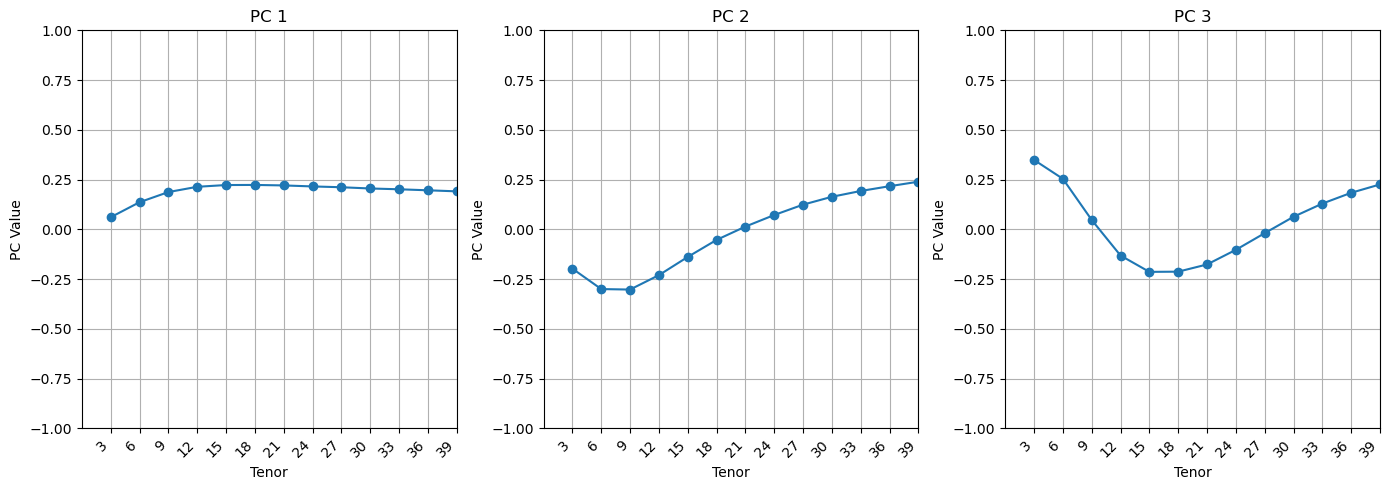

In [143]:
lambd, E = pca_port(portfolio, Q)
num_columns = E.shape[1]  
tenors = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]

plt.figure(figsize=(14, 5))

for i in range(num_columns):
    plt.subplot(1, 3, i + 1)
    plt.plot(tenors, E[3:16, i], marker='o', linestyle='-')
    plt.title(f'PC {i + 1}')
    plt.xlabel('Tenor')
    plt.ylabel('PC Value')
    plt.xticks(
        ticks=tenors,
        labels=[f'{month}' for month in tenors],
        rotation=45,  
        ha='right'    
    )
    plt.xlim(0, 39)
    plt.ylim(-1, 1)
    plt.grid(True)

plt.tight_layout()
plt.show()

Portfolio hedged by receiving 6M, receiving 1Y and paying 2Y 

In [144]:
tgt_irs = IRS(
    effective=dt(2025, 3, 21), 
    termination="1y", 
    spec="usd_irs",
    curves=curve_irs,
    notional=-1e6, 
)

In [145]:
tgt_irs.analytic_delta(curve=curve_irs)

<Dual: -97.862528, (irs0, irs1, irs2, ...), [-0.0, -0.0, -0.0, ...]>

In [146]:
def tgt_notional(tgt_delta):
        sensitivity_factor = tgt_irs.analytic_delta(curve=curve_irs).real / -1e6
        return tgt_delta / sensitivity_factor

tgt_notional(-22478)

-229689549.43988904

In [147]:
hedge_instruments = [
    IRS(dt(2025, 3, 21), "6M", spec="usd_irs", notional=-178280690, curves="irs"),
    IRS(dt(2025, 3, 21), "1Y", spec="usd_irs", notional=-229689549, curves="irs"),
    IRS(dt(2025, 3, 21), "2Y", spec="usd_irs", notional=13510338, curves="irs"),
]

In [148]:
for instrument in hedge_instruments:
    print(float(instrument.rate(solver=solver_irs)))

4.221804099196816
4.046655274003683
3.8065724006395127


In [149]:
portfolio.instruments.extend(hedge_instruments)

In [150]:
S_xpar = np.matmul(solver_fwd.jacobian(solver_par), portfolio.delta(solver=solver_fwd).to_numpy())
S_simple_par = S_xpar.droplevel(0)              
S_vec_par = np.asarray(S_simple_par, float).reshape(-1,1)

In [151]:
portfolio.delta(solver=solver_full).style.format("{:,.2f}")

In [152]:
S_xpar.style.format("{:,.2f}")

In [153]:
S_xpar.sum()

0    630.292801
dtype: float64

In [154]:
portfolio.npv(curves=curve_irs)

{'usd': <Dual: -0.000000, (irs0, irs1, irs2, ...), [71665540.0, 3804958.4, 6396521.1, ...]>}

In [155]:
portfolio.gamma(solver=solver_par).sum().sum()

0.18241502134856616

In [156]:
display(var_dataframe(Q_par, Q_mod, covar))
display(Strade_dataframe(covar, covar_smt, covar_smt_impact, covar_alloc))
display(Smodtrade_dataframe(inverse_matrix, covar, covar_smt, covar_smt_impact, covar_alloc))
display(PCA_dataframe(pca_risk, covar, pca_covar_alloc))
display(mmt_dataframe(covar, covar_mmt, covar_mmt_impact))

,VaR
c,"2,108"
VaR 5%,"-3,467"
VaR 1%,"-4,903"
c mod,"2,108"


,S par,S_trade,c_impact,%,VaR alloc
1H5,0,-714,-29,-1,0
1J5,0,-268,-29,-1,0
1K5,0,-84,-7,-0,0
H5,0,-82,-13,-1,0
M5,0,25,-4,-0,0
U5,0,9,-1,-0,0
Z5,0,-6,-0,-0,0
H6,0,-10,-1,-0,0
M6,0,-5,-0,-0,0
U6,0,2,-0,-0,0


,S mod,S_trade,c_impact,%,VaR alloc
1H5,0,-714,-29,-1,0
1J5,0,-268,-29,-1,0
1K5,0,-84,-7,-0,0
H5,0,-82,-13,-1,0
M5,0,25,-4,-0,0
U5,0,9,-1,-0,0
Z5,0,-6,-0,-0,0
H6,0,-10,-1,-0,0
M6,0,-5,-0,-0,0
U6,0,2,-0,-0,0


,Sfwd,c,Percentage
PC1,-3,3,0
PC2,-40,49,2
PC3,-139,105,5


,"(19, 23, 27)","(17, 19, 23)"
1H5,0,0
1J5,0,0
1K5,0,0
H5,0,0
M5,0,0
U5,0,0
Z5,0,0
H6,0,0
M6,0,0
U6,0,0


Creates a subsequent opening curve from a previous day's closing curve. Intial node date is moved and forward curve is preserved for overnight carry PnL accounting. 

In [157]:
translated_curve_irs = curve_irs.translate(dt(2025, 3, 20))

In [158]:
curve_irs.nodes.values

[<Dual: 1.000000, (irs0, irs1, irs2, ...), [1.0, 0.0, 0.0, ...]>,
 <Dual: 0.998560, (irs0, irs1, irs2, ...), [0.0, 1.0, 0.0, ...]>,
 <Dual: 0.998439, (irs0, irs1, irs2, ...), [0.0, 0.0, 1.0, ...]>,
 <Dual: 0.994024, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.988990, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.987853, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.987738, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.984337, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.978956, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.977680, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.977572, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.974496, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.970187, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.968188, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.967985, (irs0, irs1, irs2, ...), [0.0, 0.0, 0.0, ...]>,
 <Dual: 0.

In [159]:
translated_curve_irs.nodes.values

[<Dual: 1.000000, (9c5d80), [1.0]>,
 <Dual: 0.998680, (irs0, irs1, irs2, ...), [-0.9, 0.9, 0.0, ...]>,
 <Dual: 0.998559, (irs0, irs1, irs2, ...), [-0.9, -0.1, 1.0, ...]>,
 <Dual: 0.994143, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.989108, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.987972, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.987857, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.984455, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.979073, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.977797, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.977690, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.974613, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.970303, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.968304, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.968102, (irs0, irs1, irs2, ...), [-0.9, -0.1, 0.0, ...]>,
 <Dual: 0.965

In [160]:
translated_curve_irs_json = translated_curve_irs.to_json()  

from pathlib import Path
Path("translated_curve_irs.json").write_text(translated_curve_irs_json, encoding="utf-8")

2466

In [161]:
translated_curve_sofr = curve_sofr.translate(dt(2025, 3, 20))

In [162]:
translated_curve_sofr_json = translated_curve_sofr.to_json()  

Path("translated_curve_sofr.json").write_text(translated_curve_sofr_json, encoding="utf-8")

1173

See Curve 3_20.ipynb